# Spectroscopic Trace tutorial

This tutorial will walk through the derivation of a spectroscopic trace model and extraction using astropy tools.

A spectroscopic trace is the path of a point source (star) spectrum through a two-dimensional dispersed spectrum.  The trace is needed because, in general, spectra are not perfectly aligned with the axes of a detector.

# Step 1: Examine the spectrum

We'll work with a 2D spectrum that contains *no* attached metadata, so we have to infer many of the features ourselves.

All we know is that this is a spectrum of a star, Aldebaran.

Our data are, strangely, in the form of a .bmp (bitmap) file.

In [1]:
from PIL import Image
import numpy as np

In [2]:
spectrum_filename = "aldebaran_3s_1.bmp"

In [3]:
image_data = Image.open(spectrum_filename)

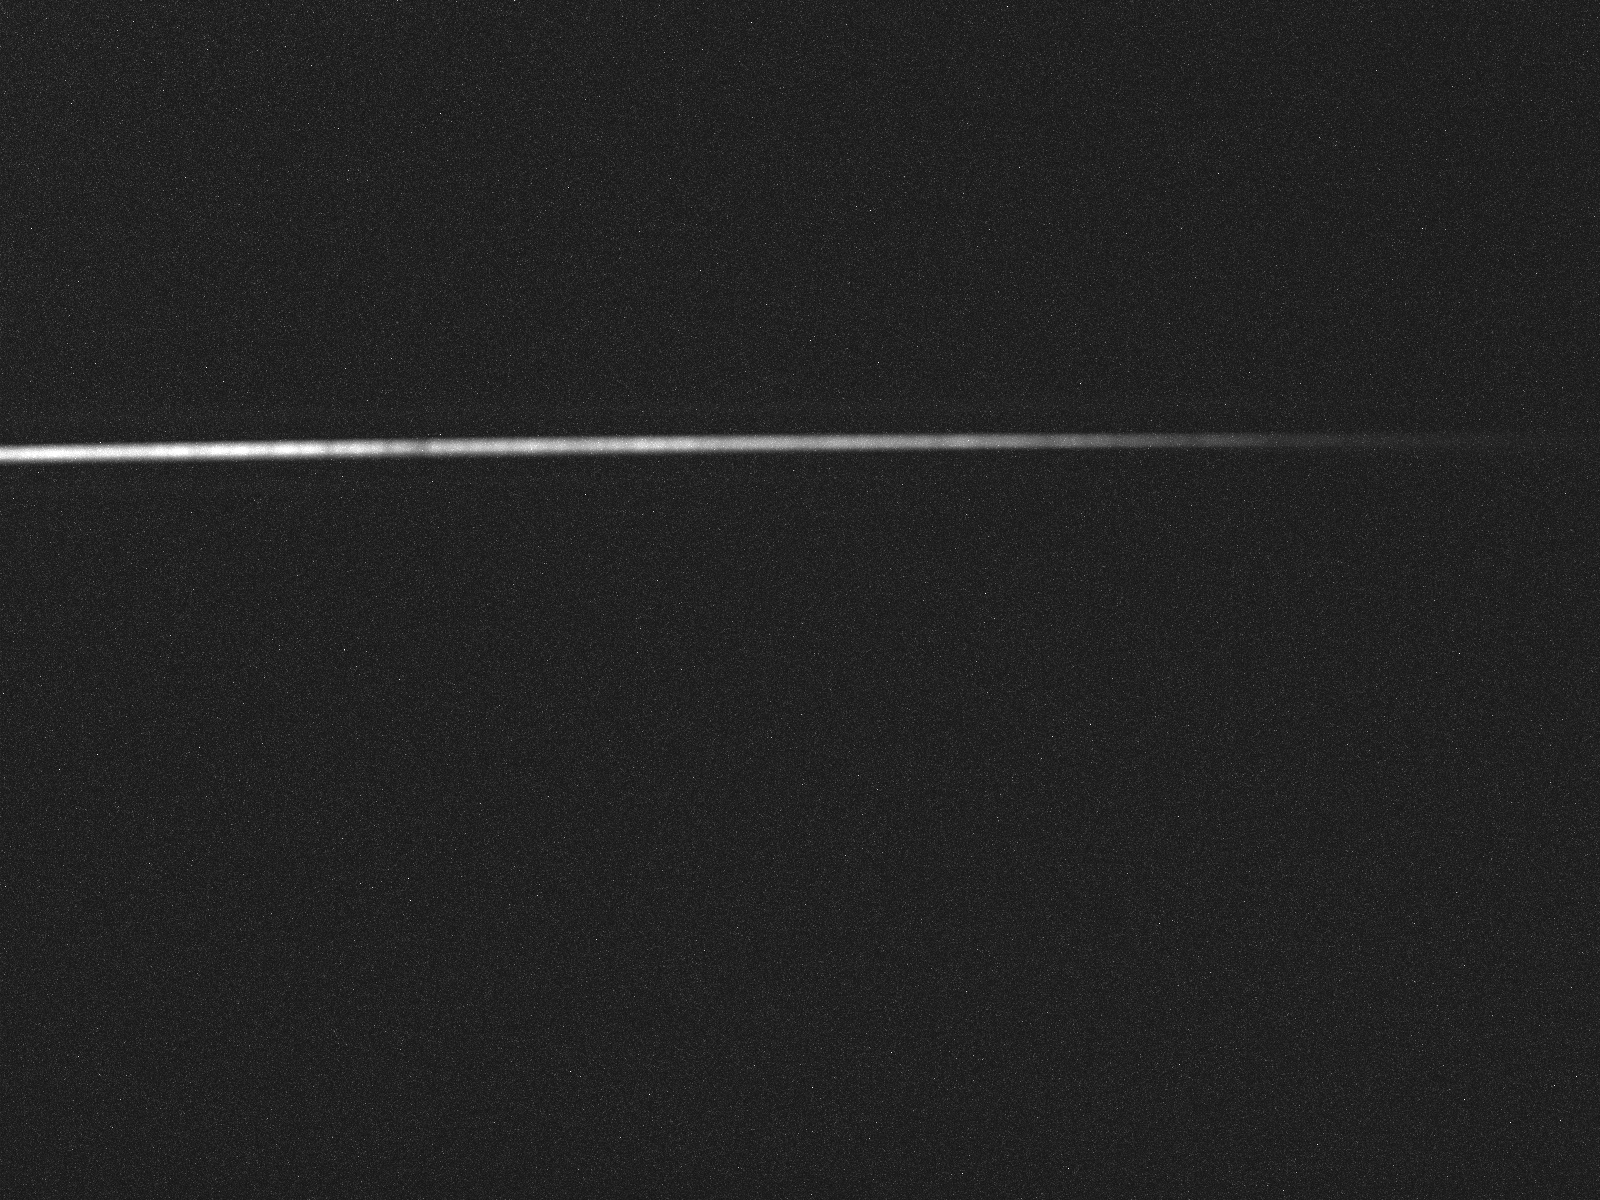

In [4]:
# because this is an image, simply entering on the command line will show it
image_data

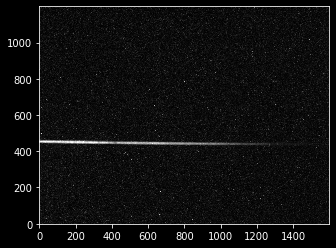

In [5]:
# but we'd like to see it with axes labeled
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.matplotlib.style.use('dark_background')
pl.imshow(image_data, cmap='gray')

The main goal of the trace is to obtain a two-dimensional model defining the position of the light along the detector.

We're going to start by assuming that wavelength dispersion is in the X-direction and the Y-direction is entirely spatial.  This is an approximation, but evidently (by looking at the image), it's a decent one.

# Step 2a. Try to find the spine to trace using argmax

To obtain the trace, we first measure the Y-value at each X-value.  we'll start with the trivial approach of using `argmax`:

In [6]:
yvals = np.argmax(image_data, axis=0)
xvals = np.arange(image_data.width)

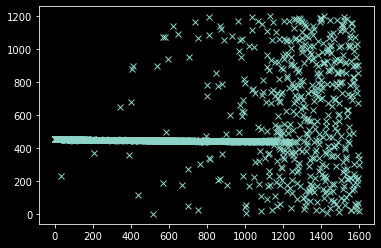

In [7]:
pl.plot(xvals, yvals, 'x')

There's a pretty clear line going through, but also a lot of junk.

We can get rid of most of the junk just by filtering it out:

In [8]:
bad_pixels = (yvals < 400) | (yvals > 500)

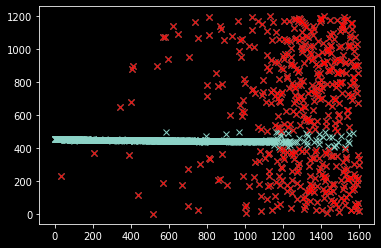

In [9]:
pl.plot(xvals, yvals, 'x')
pl.plot(xvals[bad_pixels], yvals[bad_pixels], 'rx')

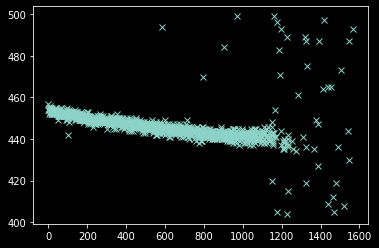

In [10]:
pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], 'x')

In [11]:
bad_pixels = (yvals < 425) | (yvals > 460)

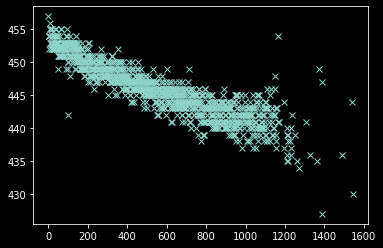

In [12]:
pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], 'x')

The stuff at x>1100 looks bad, but there's still signal out there.

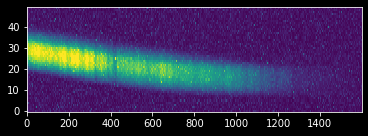

In [13]:
image_array = np.array(image_data)
image_array = image_array - np.median(image_array)
pl.imshow(image_array[425:475,:])
pl.gca().set_aspect(10)

# Step 2b: Use moment analysis to extract a spine to trace

We can use moments to get measurements of all the data

In [14]:
yaxis = np.repeat(np.arange(425, 475)[:,None], image_array.shape[1], axis=1)
weighted_yaxis_values = np.average(yaxis, axis=0, weights=image_array[425:475,:])

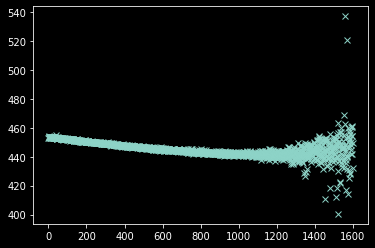

In [15]:
pl.plot(xvals, weighted_yaxis_values, 'x')

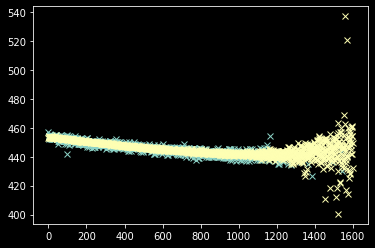

In [16]:
pl.plot(xvals[~bad_pixels], yvals[~bad_pixels], 'x')
pl.plot(xvals, weighted_yaxis_values, 'x')

That's a decent set of data, we'll use the moments instead of the argmax.  There's still some data to flag out, though:

In [17]:
bad_moments = (weighted_yaxis_values > 460) | (weighted_yaxis_values < 430)

# Step 3. Fit the trace profile

In [18]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

In [19]:
polymodel = Polynomial1D(degree=3)
linfitter = LinearLSQFitter()
fitted_polymodel = linfitter(polymodel, xvals[~bad_moments], weighted_yaxis_values[~bad_moments])

In [26]:
fitted_polymodel

<Polynomial1D(3, c0=453.31622273, c1=-0.01256666, c2=-0.00000651, c3=0.00000001)>

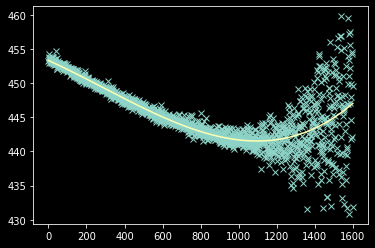

In [20]:
pl.plot(xvals[~bad_moments], weighted_yaxis_values[~bad_moments], 'x')
pl.plot(xvals, fitted_polymodel(xvals))

Arguably, we should toss out the data at >1400 pixels since there's no clear signal there.

# Step 4. Obtain a trace profile

Now we can extract the data along that trace.

We want to take a "profile" of the trace to see how many pixels on either side of the line we should include.

In [21]:
# start by taking +/- 15 pixels
npixels_to_cut = 15
trace_center = fitted_polymodel(xvals)
cutouts = np.array([image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)])
cutouts.shape

(1600, 30)

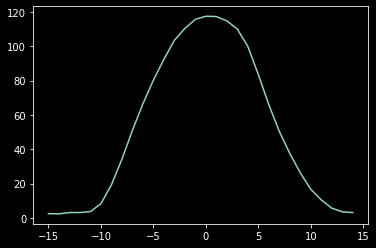

In [29]:
mean_trace_profile = cutouts.mean(axis=0)
trace_profile_xaxis = np.arange(-npixels_to_cut, npixels_to_cut)
pl.plot(trace_profile_xaxis, mean_trace_profile)

In [32]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=mean_trace_profile)
model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
fitted_trace_profile

<Gaussian1D(amplitude=123.66048266, mean=0.17770841, stddev=5.11726616)>

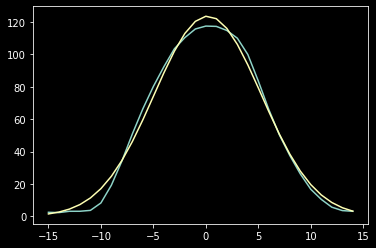

In [33]:
pl.plot(trace_profile_xaxis, mean_trace_profile)
pl.plot(trace_profile_xaxis, model_trace_profile)

# Step 5. Extract the traced spectrum

Then we can obtain our spectrum by taking the trace-weighted average:    

In [23]:
spectrum = np.array([np.average(image_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=mean_trace_profile)
                     for yval, ii in zip(trace_center, xvals)])
spectrum.shape

(1600,)

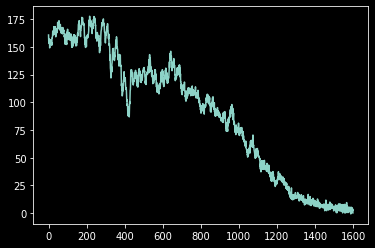

In [24]:
pl.plot(spectrum)

# Step 6: Repeat for another star

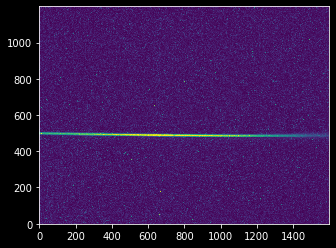

In [41]:
image_array_2 = np.array(Image.open('deneb_3s_13.63g_1.bmp'))
pl.imshow(image_array_2)

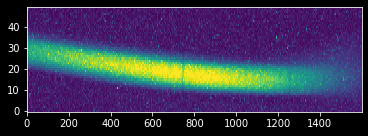

In [45]:
pl.imshow(image_array_2[470:520,:])
pl.gca().set_aspect(10)

In [50]:
yaxis2 = np.repeat(np.arange(470, 520)[:,None], image_array_2.shape[1], axis=1)
weighted_yaxis_values2 = np.average(yaxis2, axis=0, weights=image_array_2[470:520,:])
polymodel2 = Polynomial1D(degree=3)
fitted_polymodel2 = linfitter(polymodel2, xvals, weighted_yaxis_values2)
trace_center2 = fitted_polymodel2(xvals)

In [53]:
spectrum2 = np.array([np.average(image_array_2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=mean_trace_profile)
                     for yval, ii in zip(trace_center2, xvals)])

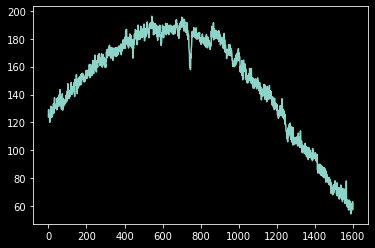

In [54]:
pl.plot(spectrum2)

DONE!  You have traced and extracted a spectrum.